In [353]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy

import re
from gseapy import Biomart

import matplotlib.pyplot as plt
from scripts import aesthetics

aesthetics.activate_paper_rcParams()

# CWAS Gene Set Enrichment

In this notebook, we explore whether categories significantly enriched for SVs in cases vs. controls reflect any higher level biological process. One way to do this is with gene set enrichment.

# What is gene set enrichment anyway?

The idea of gene set enrichment is that in a list of genes (i.e. upregulated genes, or genes targeted by a "category"), if it were random, would have a certain degree of overlap with a gene set by pure chance. The idea of gene set enrichment is that we determine overlap with a gene set, and compare this to the background.

This is a bit weirder with these data, since we have actual _SV counts_. The underlying test for gene set enrichment is a fisher's exact test, which works perfectly fine with counts in that way, but I'm not entirely sure it's right to do?

We'll do it anyway I guess.

# Load in the data

We load in the SVs and dosages, which we'll need.

## Read in SVs

In [103]:
# define the folder name for all our results
folder_name = "processed-data-v2.5.2"

# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

# list of genes that are annotated - drop ensembl IDs
gene_ref = pd.read_csv("ref/gencode_hg38_protein_coding_genes_for_annotation_7_31_23.txt")
gene_ref = gene_ref[~gene_ref['value'].str.startswith('ENSG00')]
gene_ref = gene_ref['value'].tolist()

Load metadata and SVs

In [3]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
nbl_cases = metadata[
    (metadata["neuroblastoma_case"] == True)
]["entity:sample_id"].tolist()

nbl_controls = metadata[
    (metadata["neuroblastoma_control"] == True)
]["entity:sample_id"].tolist()

Now we load the SVs. We'll eventually combine discovery and validation data, but it's easiest to keep them separate for now, since the SVs and dosages are not fully overlapping.

In [4]:
###############
##### SVs #####
###############
svs = pd.read_csv(
    sv_path,
    sep="\t",
)

###############
### Dosages ###
###############
dosages = pd.read_csv(
    dosages_path,
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [5]:
###########
### SVs ###
###########
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

nbl_noncoding_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_noncoding_SVs_in_each_category_list_combined_BURDEN_TESTING_with_col_names_11_3_23.txt', sep='\t')
nbl_noncoding_svs = nbl_noncoding_svs.rename(columns = {'emd': 'end'})

# combine the SVs
nbl_coding_svs['sv_category'] = 'coding'
nbl_noncoding_svs['sv_category'] = 'non-coding'

nbl_category_svs = pd.concat([nbl_coding_svs, nbl_noncoding_svs])
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [6]:
#########################
### FRAMEWORK RESULTS ###
#########################
nbl_singleton_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_coding_framework_results[['af_category', 'sv_category']] = ['singleton', 'coding']

nbl_rare_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_coding_framework_results[['af_category', 'sv_category']] = ['rare', 'coding']

nbl_singleton_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_noncoding_framework_results[['af_category', 'sv_category']] = ['singleton', 'non-coding']

nbl_rare_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_noncoding_framework_results[['af_category', 'sv_category']] = ['rare', 'non-coding']

nbl_framework_results = pd.concat([nbl_singleton_coding_framework_results, nbl_rare_coding_framework_results, 
                                   nbl_singleton_noncoding_framework_results, nbl_rare_noncoding_framework_results])

In [7]:
nbl_framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,...,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,...,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,...,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [8]:
nbl_coding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt",
    sep="\t",
)

nbl_noncoding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt",
    sep="\t",
)

# Walk through a coding example

Let's extract out all the data that we need to examine the highest result for a single hallmark gene set.

In [174]:
test_framework = nbl_framework_results.query('af_category == "singleton" & sv_category == "coding"').loc[0, ["category_name"]].item()
framework_components = test_framework.split(".")
genic_relationship = framework_components[2]
test_framework, genic_relationship

('ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
 'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP')

In [175]:
nbl_coding_framework.head(5)

,sv_type,frequency,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_COPY_GAIN,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_INTRAGENIC_EXON_DUP,missense_constrained,ANY,cosmic_cancer_genes
2,CPX_or_INV,NaN,PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,unconstrained,NaN,germline_CPGs
3,INS_ALL,NaN,ANY,ANY,NaN,base_excision_repair_genes
4,ANY,NaN,NaN,NaN,NaN,chromatin_organization_genes


We identify the SVs that are part of that category.

In [176]:
svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == "coding") & 
                                   (nbl_category_svs["category"] == test_framework)]

# subset the actual SV matrix
svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]

svs_in_category.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,...,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v3.1_sv_POPMAX_AF,gnomad_v3.1_sv_POPMAX_FREQ_HOMREF,gnomad_v3.1_sv_POPMAX_FREQ_HET,gnomad_v3.1_sv_POPMAX_FREQ_HOMALT,gnomad_v3.1_sv_POPMAX_CN_FREQ,gnomad_v3.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
64,chr1,923800,943501,PedSV.2.5.2_DEL_chr1_80,DEL,1,0.000077,depth,13038,False,...,0.0,NaN,NaN,0.000107,NaN,NaN,NaN,NaN,NaN,PASS
152,chr1,1240217,1243609,PedSV.2.5.2_DEL_chr1_210,DEL,1,0.000074,manta,13462,True,...,0.0,NaN,NaN,0.000018,NaN,NaN,NaN,NaN,NaN,PASS


In [177]:
svs_in_category.shape

(3837, 952)

Next, we determine the genes in question. We reference the column where the genes can be found, `genic_relationship`. We have to split this one in half.

In [178]:
genic_relationships = genic_relationship.split("_or_")
genic_relationships

['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']

In [179]:
svs_in_category[genic_relationships].head()

,PREDICTED_LOF,PREDICTED_PARTIAL_EXON_DUP
64,SAMD11,NaN
152,C1QTNF12,NaN
162,"ACAP3,INTS11,PUSL1,SCNN1D",NaN
173,CPTP,NaN
198,"TMEM88B,VWA1",NaN


We should be a bit more careful if any results turn up positive, but for now we'll just register an SV as contributing to a count for that gene.

In [181]:
nbl_sv_dosages = (
    dosages
    .set_index("ID")
    .loc[svs_in_category["name"].tolist(), nbl_cases + nbl_controls]
)
nbl_sv_dosages.head(2)

,PT_00QYKRAX,PT_00Y8C0XA,PT_025YMME2,PT_02AE4RSP,PT_02SNWVRF,PT_06Z51EN5,PT_0CKD259J,PT_0GMP9VVY,PT_0MVMPZKX,PT_11XN6CG5,...,ssi_26401,ssi_26409,ssi_26411,ssi_26422,ssi_26442,ssi_26452,ssi_26453,ssi_26458,ssi_26459,ssi_26463
ID,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_DEL_chr1_80,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PedSV.2.5.2_DEL_chr1_210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
nbl_sv_dosages.shape

(3837, 5519)

So we now have the dosages for both cases and controls. We analyze these two datasets separately, and will need to determine post-hoc if there is a unique enrichment in cases vs. control. Additionally, we need to drop samples that are poorly genotyped for these SVs. The strategy that Ryan and Riaz used is to drop samples with >5% `NaN` genotyping rate. We do that here.

In [183]:
kept = pd.isnull(nbl_sv_dosages).sum(axis = 0) / len(nbl_sv_dosages) < 0.05

nbl_kept_cases = list(set(nbl_cases) & set(kept[kept].index))
nbl_kept_controls = list(set(nbl_controls) & set(kept[kept].index))

In [184]:
nbl_sv_dosages = nbl_sv_dosages.loc[:, kept]

In [185]:
nbl_sv_dosages.shape

(3837, 5346)

So now we can generate our counts, separately for cases and controls. We can ignore `NaNs`.

In [186]:
sv_counts_cases = nbl_sv_dosages[nbl_kept_cases].fillna(0).sum(axis=1).sort_values()
sv_counts_controls = nbl_sv_dosages[nbl_kept_controls].fillna(0).sum(axis=1).sort_values()
sv_counts_cases.head()

ID
PedSV.2.5.2_DEL_chr1_80       0.0
PedSV.2.5.2_DEL_chr12_7605    0.0
PedSV.2.5.2_DEL_chr12_7621    0.0
PedSV.2.5.2_DEL_chr12_7627    0.0
PedSV.2.5.2_DEL_chr12_7653    0.0
dtype: float64

Note that some SVs have 0 counts, presumably because those SVs are present in non-neuroblastoma samples? Let's just verify that.

In [187]:
test_sv = dosages.set_index("ID").loc["PedSV.2.5.2_DEL_chr1_80"].iloc[3:]
test_sv[test_sv == 1]

SJ042098    1.0
Name: PedSV.2.5.2_DEL_chr1_80, dtype: object

In [188]:
metadata.set_index("entity:sample_id").loc["SJ042098"]

ancestry_short_variant_inferred_or_reported                                       NaN
batch                                          PedSV.v2-wgd_score_1-median_coverage_2
study                                                                          StJude
disease                                                                  osteosarcoma
family_id                                                                         NaN
                                                                ...                  
pancan_control                                                                  False
osteosarcoma_control                                                            False
neuroblastoma_control                                                           False
ewing_control                                                                   False
sex                                                                                 0
Name: SJ042098, Length: 73, dtype: object

Yep. Alright, we can move on and actually count things up. First, how many SVs are we actually dealing with here?

In [189]:
sv_counts_cases.sum(), sv_counts_controls.sum()

(438.0, 2441.0)

We can see that the cases have a higher proportion of counts relative to the proportion of samples, which is what we expect (this category is significant).

Let's see what happens when we convert to gene counts.

In [190]:
len(svs_in_category)

3837

In [191]:
genes_in_svs = svs_in_category[['name'] + genic_relationships].set_index('name')

In [192]:
gene_counts = {'cases': [], 'controls': []}
for cohort, sv_counts in zip(['cases', 'controls'], [sv_counts_cases, sv_counts_controls]):

    sample_genes_in_svs = genes_in_svs.copy()
    sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

    # simple enough to go through
    cohort_gene_counts = []
    for index, row in sample_genes_in_svs.iterrows():
        if not pd.isnull(row['PREDICTED_LOF']):
            cohort_gene_counts += row['PREDICTED_LOF'].split(',') * row['count']
        if not pd.isnull(row['PREDICTED_PARTIAL_EXON_DUP']):
            cohort_gene_counts += row['PREDICTED_PARTIAL_EXON_DUP'].split(',') * row['count']

    gene_counts[cohort] = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), index = ['gene', 'count']).T

In [193]:
gene_counts['cases'].shape, gene_counts['controls'].shape

((511, 2), (2790, 2))

Great. Now we can try merging this with a gene set to test significance. We'll try it with a small, well characterized gene set first.

In [194]:
hallmark = gp.get_library(name='MSigDB_Hallmark_2020')

In [195]:
g2m_checkpoint = hallmark['G2-M Checkpoint']
g2m_checkpoint = [g for g in g2m_checkpoint if g in gene_ref]
len(g2m_checkpoint)

199

We need to calculate 4 numbers for our Fisher's exact test:

1. The counts of genes in the gene set and category
2. The counts of genes in the category and not the gene set
3. The counts of genes in the gene set and not the category
4. The counts of genes in neither (~19k)

We then do a fisher's exact test.

In [196]:
for cohort in ['cases', 'controls']:
    
    cohort_gene_counts = gene_counts[cohort]
    
    genes_in_category_and_gs = cohort_gene_counts[cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()
    genes_in_category_and_not_gs = cohort_gene_counts[~cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()

    genes_not_in_category_and_in_gs = len(set(g2m_checkpoint) - set(cohort_gene_counts['gene']))
    genes_not_in_category_and_not_gs = len(gene_ref) - genes_not_in_category_and_in_gs
    
    cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                       [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])
    print(scipy.stats.fisher_exact(cont_table))

(0.9038212804808461, 1.0)
(0.9764931744388707, 1.0)


So neither cases nor controls are significantly enriched for G2-M checkpoint genes. But at least this process makes sense. Now we can generalize a bit.

In [197]:
hallmark_results = []
for gs, genes in hallmark.items():
    
    genes = [g for g in genes if g in gene_ref]
    
    # store the expected frequency
    expected = f'{len(genes)}/{len(gene_ref)}'
    row = [gs, expected]
    
    for cohort in ['cases', 'controls']:
        
        cohort_gene_counts = gene_counts[cohort]
        
        upper_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(genes)]['count'].sum()
        upper_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(genes)]['count'].sum()

        bottom_left = len(set(genes) - set(cohort_gene_counts['gene']))
        botttom_right = len(gene_ref) - bottom_left

        cont_table = np.array([[upper_left, upper_right], 
                               [bottom_left, botttom_right]])
        res, p = scipy.stats.fisher_exact(cont_table)

        # provide the expected and the data frequencies
        data = f'{upper_left}/{upper_left + upper_right}'
        row += [res, p, data]
        
    hallmark_results.append(row)
    
col_names = ['gene_set', 'expected', 'case_stat', 'case_p', 'case_data', 'control_stat', 'control_p', 'control_data']
hallmark_results = pd.DataFrame(hallmark_results, columns = col_names)

In [198]:
hallmark_results.query('case_p < 0.05')

,gene_set,expected,case_stat,case_p,case_data,control_stat,control_p,control_data
11,Adipogenesis,200/19201,2.670747,0.001485,14/547,0.783782,0.316489,24/3334
25,mTORC1 Signaling,199/19201,0.000000,0.007389,0/547,0.750897,0.228387,23/3334


Interesting... we'll follow up on that in a second.

# Walk through a non-coding example

Let's extract out all the data that we need to examine the highest result for a single hallmark gene set.

In [199]:
# we'll select a non-tad framework for testing
nontad_test_framework = nbl_framework_results[(nbl_framework_results['af_category'] == "singleton") & 
                      (nbl_framework_results['sv_category'] == "non-coding") &
                      (~nbl_framework_results['category_name'].str.contains('tad'))].iloc[0]['category_name']

framework_components = nontad_test_framework.split(".")
genic_relationship = framework_components[2]
test_framework, genic_relationship

('ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
 'ANY')

This is good practice - we see that the genic relationship here is `ANY`. In the context of noncoding analysis, this has a specific meaning.

In [200]:
nbl_noncoding_framework.head(6)

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,neuroblastoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,neuroblastoma_chromHMM15_Enh,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,neuroblastoma_chromHMM15_Enh_conserved,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,neuroblastoma_chromHMM15_EnhG,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,neuroblastoma_chromHMM15_EnhG_conserved,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,neuroblastoma_H3K27Ac_peak,NaN,NaN,NaN,NaN


So `ANY` really means `PREDICTED_INTERGENIC | PREDICTED INTRONIC | PREDICTED PROMOTER | PREDICTED UTR`

In [201]:
genic_relationships = ['PREDICTED_INTERGENIC', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']

# a weird feature of these data is that PREDICTED_INTERGENIC is actually boolean, and refers to PREDICTED_NEAREST_TSS
genic_relationships[genic_relationships.index('PREDICTED_INTERGENIC')] = 'PREDICTED_NEAREST_TSS'

Subset down to those SVssvs

In [202]:
svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == "non-coding") & 
                                   (nbl_category_svs["category"] == nontad_test_framework)]

# subset the actual SV matrix
svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]

svs_in_category.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,...,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v3.1_sv_POPMAX_AF,gnomad_v3.1_sv_POPMAX_FREQ_HOMREF,gnomad_v3.1_sv_POPMAX_FREQ_HET,gnomad_v3.1_sv_POPMAX_FREQ_HOMALT,gnomad_v3.1_sv_POPMAX_CN_FREQ,gnomad_v3.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
120,chr1,1116266,1116473,PedSV.2.5.2_DEL_chr1_165,DEL,1,0.000074,manta,13462,True,...,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,PASS
137,chr1,1157302,1157390,PedSV.2.5.2_DEL_chr1_186,DEL,1,0.000074,wham,13462,False,...,0.0,NaN,NaN,0.000031,NaN,NaN,NaN,NaN,NaN,PASS


In [203]:
svs_in_category.shape

(3021, 952)

In [204]:
svs_in_category[genic_relationships].head()

,PREDICTED_NEAREST_TSS,PREDICTED_INTRONIC,PREDICTED_PROMOTER,PREDICTED_UTR
120,NaN,NaN,C1orf159,NaN
137,TTLL10,NaN,NaN,NaN
224,NaN,ATAD3B,NaN,NaN
584,NaN,NaN,C1orf174,NaN
836,HES3,NaN,NaN,NaN


We should be a bit more careful if any results turn up positive, but for now we'll just register an SV as contributing to a count for that gene.

In [205]:
nbl_sv_dosages = (
    dosages
    .set_index("ID")
    .loc[svs_in_category["name"].tolist(), nbl_cases + nbl_controls]
)
nbl_sv_dosages.head(2)

,PT_00QYKRAX,PT_00Y8C0XA,PT_025YMME2,PT_02AE4RSP,PT_02SNWVRF,PT_06Z51EN5,PT_0CKD259J,PT_0GMP9VVY,PT_0MVMPZKX,PT_11XN6CG5,...,ssi_26401,ssi_26409,ssi_26411,ssi_26422,ssi_26442,ssi_26452,ssi_26453,ssi_26458,ssi_26459,ssi_26463
ID,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_DEL_chr1_165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PedSV.2.5.2_DEL_chr1_186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Again subset our dosage matrix, dropping samples with bad GT rates

In [206]:
kept = pd.isnull(nbl_sv_dosages).sum(axis = 0) / len(nbl_sv_dosages) < 0.05

nbl_kept_cases = list(set(nbl_cases) & set(kept[kept].index))
nbl_kept_controls = list(set(nbl_controls) & set(kept[kept].index))

In [207]:
nbl_sv_dosages = nbl_sv_dosages.loc[:, kept]

In [208]:
nbl_sv_dosages.shape

(3021, 5346)

In [209]:
sv_counts_cases = nbl_sv_dosages[nbl_kept_cases].fillna(0).sum(axis=1).sort_values()
sv_counts_controls = nbl_sv_dosages[nbl_kept_controls].fillna(0).sum(axis=1).sort_values()
sv_counts_cases.head()

ID
PedSV.2.5.2_DEL_chr1_165     0.0
PedSV.2.5.2_DEL_chr12_612    0.0
PedSV.2.5.2_DEL_chr12_615    0.0
PedSV.2.5.2_DEL_chr12_705    0.0
PedSV.2.5.2_DEL_chr12_839    0.0
dtype: float64

First, how many SVs are we actually dealing with here?

In [210]:
sv_counts_cases.sum(), sv_counts_controls.sum()

(339.0, 1962.0)

So maybe that's not so bad? We'll see what happens.

In [211]:
genes_in_svs = svs_in_category[['name'] + genic_relationships].set_index('name')

In [212]:
gene_counts = {'cases': [], 'controls': []}
for cohort, sv_counts in zip(['cases', 'controls'], [sv_counts_cases, sv_counts_controls]):

    sample_genes_in_svs = genes_in_svs.copy()
    sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

    # simple enough to go through
    cohort_gene_counts = []
    for index, row in sample_genes_in_svs.iterrows():
        for col in genic_relationships:
            if not pd.isnull(row[col]):
                cohort_gene_counts += row[col].split(',') * row['count']

    gene_counts[cohort] = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), index = ['gene', 'count']).T

In [213]:
gene_counts['cases'].shape, gene_counts['controls'].shape

((314, 2), (1565, 2))

Calculate with Fisher's exact:

In [214]:
for cohort in ['cases', 'controls']:
    
    cohort_gene_counts = gene_counts[cohort]
    
    genes_in_category_and_gs = cohort_gene_counts[cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()
    genes_in_category_and_not_gs = cohort_gene_counts[~cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()

    genes_not_in_category_and_in_gs = len(set(g2m_checkpoint) - set(cohort_gene_counts['gene']))
    genes_not_in_category_and_not_gs = len(gene_ref) - genes_not_in_category_and_in_gs
    
    cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                       [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])
    print(scipy.stats.fisher_exact(cont_table))

(0.8683368869936035, 1.0)
(1.3816026445435954, 0.14262785040075765)


In [215]:
hallmark_results = []
for gs, genes in hallmark.items():
    
    # genes = [g for g in genes if g in gene_ref]
    
    # store the expected frequency
    expected = f'{len(genes)}/{len(gene_ref)}'
    row = [gs, expected]
    
    for cohort in ['cases', 'controls']:
        
        cohort_gene_counts = gene_counts[cohort]
        
        top_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(genes)]['count'].sum()
        top_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(genes)]['count'].sum()

        bottom_left = len(set(genes) - set(cohort_gene_counts['gene']))
        botttom_right = len(gene_ref) - bottom_left

        cont_table = np.array([[top_left, top_right], 
                               [bottom_left, botttom_right]])
        res, p = scipy.stats.fisher_exact(cont_table)

        # provide the expected and the data frequencies
        data = f'{top_left}/{top_left + top_right}'
        row += [res, p, data]
        
    hallmark_results.append(row)
    
col_names = ['gene_set', 'expected', 'case_stat', 'case_p', 'case_data', 'control_stat', 'control_p', 'control_data']
hallmark_results = pd.DataFrame(hallmark_results, columns = col_names)

In [216]:
hallmark_results.query('case_p < 0.05')

,gene_set,expected,case_stat,case_p,case_data,control_stat,control_p,control_data
0,TNF-alpha Signaling via NF-kB,200/19201,3.034415,0.002708,10/338,2.047719,2.785264e-04,36/1981
3,Mitotic Spindle,199/19201,2.412819,0.022825,8/338,1.863254,2.358557e-03,33/1981
11,Adipogenesis,200/19201,2.400126,0.023432,8/338,1.405359,1.166004e-01,26/1981
16,Protein Secretion,96/19201,3.118717,0.026645,5/338,1.226758,4.865993e-01,11/1981
23,Unfolded Protein Response,113/19201,2.629969,0.048101,5/338,0.737422,5.164636e-01,8/1981
38,UV Response Dn,144/19201,3.863425,0.000918,9/338,3.906664,1.042503e-11,44/1981
43,Bile Acid Metabolism,112/19201,2.654460,0.046622,5/338,1.025317,8.726269e-01,11/1981
45,Allograft Rejection,200/19201,2.722672,0.008239,9/338,0.775782,3.962079e-01,15/1981
49,Pancreas Beta Cells,40/19201,4.516025,0.033713,3/338,2.285799,5.459697e-02,8/1981


# Generalized gene set enrichment

Alright, we've been through two examples. Now let's try generalizing across two axes--categories and gene sets. For now, we'll only neuroblastoma significant categories.

I don't know if these `p_values` are already corrected or not. I'll assume they're not.

## Define the categories for analysis

Here, we'll select which categories we want to examine. We'll stick to neuroblastoma, but we'll examine `singleton` and `rare`, as well as `noncoding` and `coding`.

Worth mentioning that the `noncoding` categories could be quite difficult to interpret.

In [217]:
nbl_analysis_categories = nbl_framework_results.query('negative_log10_p_value > 3.5')
nbl_analysis_categories.shape

(77, 22)

Here, we'll also define a helpful lookup that maps from the "collapsed" genic relationships to all their component relationships.

In [218]:
gr_coding_mapping = {'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP': ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP'],
                     'ANY': ['PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']}

gr_noncoding_mapping = {'ANY': ['PREDICTED_INTERGENIC', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']}


## Define the gene sets for analysis

Let's highlight some specific gene sets for analysis. We'll do the following:

* `MSigDB_Hallmark_2020`
* `GO_Biological_Process_2023` (this is the default for GO term analysis)
* `Reactome_2022`

We'll begin with these, and then we can add in other specific ones that might be relevant later:

### GO terms

We're using `gseapy` to get our gene sets. Unfortunately, I've discovered that the gene sets procided by `gp.get_library` _do not_ match the GO gene sets fetched by `biomaRt`. The libraries defined here are from `enrichr`, and from digging around a bit, they do not match. Maybe they're some custom file or something?

In [252]:
gene_sets = {}
for db_name in ['MSigDB_Hallmark_2020', 'Reactome_2022']:
    db = gp.get_library(name=db_name)
    gene_sets[db_name] = db

The GO terms from `gseapy` are not correct. We have pulled them directly from GO in `pull-go-terms`

In [253]:
go_output = pd.read_csv('data/cwas-results/go-gene-sets/full-go-gene-set.txt', sep ='\t')
go_output.head(2)

,go,label,genes_specific,genes_full,num_genes_panther,level,depth,num_genes_goat
0,GO:0043012,regulation of fusion of sperm to egg plasma me...,NOX5,NOX5,1.0,4.0,6.0,1.0
1,GO:0002728,negative regulation of natural killer cell cyt...,"HLA-F,CD96","HLA-F,CD96",2.0,7.0,11.0,2.0


In [254]:
gene_sets['GO_Biological_Process_Specific'] = {}
gene_sets['GO_Biological_Process_Full'] = {}

for index, row in go_output.iterrows():
    term = row['go']
    label = row['label'].strip()
    
    if not pd.isnull(row['genes_specific']):
        genes_specific = row['genes_specific'].split(',')
    else:
        genes_specific = []
    
    if not pd.isnull(row['genes_full']):
        genes_full = row['genes_full'].split(',')
    else:
        genes_full = []
        
    gene_sets['GO_Biological_Process_Specific'][label + f' ({term})'] = genes_specific
    gene_sets['GO_Biological_Process_Full'][label + f' ({term})'] = genes_full
        
    

Below is just some old code to get go terms from the broad (these are basically full)

In [255]:
# link = 'https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/c5.go.bp.v2023.2.Hs.symbols.gmt'

# import requests
# from io import StringIO

# go_terms = {}

# resp = requests.get(link).text
# gmt_io = StringIO(resp)
# for line in gmt_io:
#     line = line.strip().split('\t')
#     name = line[0]
#     genes = line[2:]
#     go_terms[name] = genes


And here's some old code to get it from Ensembl

In [256]:
# # fetch the GO ids, and then make them into 50 length chunks
# pattern = r'\((.*?)\)'
# go_id_to_go_term = {re.findall(pattern, g)[0]: g for g in gs['GO_Biological_Process_2023']}
# go_chunks = [list(go_id_to_go_term.keys())[i:i + 50] for i in range(0, len(go_id_to_go_term.keys()), 50)]

# go_results = []
# for i, go_ids in enumerate(go_chunks):
#     print(i, end = ', ')
#     queries ={'go': go_ids}
    
#     # look up the true GO ids from biomart
#     results = bm.query(dataset='hsapiens_gene_ensembl',
#                        attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go'],
#                        filters=queries)
#     go_results.append(results)
    
# go_results = pd.concat(go_results)
# go_results['go_term'] = go_results['go'].replace(go_id_to_go_term)
# go_results[['go_term', 'external_gene_name']].to_csv('ref/GO_Biological_Process_Gene_Mapping.csv', index=False)

# go_terms = pd.read_csv('ref/GO_Biological_Process_Gene_Mapping.csv').set_index('go_term')
# go_terms.head(2)

# new_go = {}
# for gs, genes in gene_sets['GO_Biological_Process_2023'].items():
#     if gs in go_terms.index:
#         correct_genes = go_terms.loc[gs]
#         new_go[gs] = correct_genes
        
# gene_sets['GO_Biological_Process_2023'] = new_go

In [257]:
adrenal_genes = pd.read_csv('ref/adrenal-specific-genes.txt', sep='\t', comment = '#')['Gene Name'].tolist()
adrenal_genes = [g for g in adrenal_genes if g in gene_ref]

gene_sets['custom'] = {'adrenal-specific-exp': adrenal_genes}

In [259]:
len(gene_sets['GO_Biological_Process_Specific'])

12558

In [263]:
gene_ref_set = set(gene_ref)

In [264]:
gs_count = 0
for db_name, db in gene_sets.items():
    print(db_name)
    gs_count += len(db.values())
    
    # ensure that all genes are in our gene reference
    for gs, genes in db.items():
        gene_sets[db_name][gs] = list(set(genes) & gene_ref_set)

gs_count

MSigDB_Hallmark_2020
Reactome_2022
GO_Biological_Process_Specific
GO_Biological_Process_Full
custom


26983

In [265]:
genes = ['BRCA1', 'BRCA1', 'BRCA2', 'TP53', 'RAD51', 'MSH1', 'MSH6']
cohort_gene_counts = pd.DataFrame(np.unique(genes, return_counts = True), index = ['gene', 'count']).T

In [266]:
test = []
for db_name, db in gene_sets.items():
    for gs, genes in db.items():
    
        # store the expected frequency
        expected = f'{len(genes)}/{len(gene_ref)}'
        row = [db_name, gs, expected]

        top_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(genes)]['count'].sum()
        top_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(genes)]['count'].sum()

        bottom_left = len(set(genes) - set(cohort_gene_counts['gene']))
        botttom_right = len(gene_ref) - bottom_left

        cont_table = np.array([[top_left, top_right], 
                               [bottom_left, botttom_right]])
        res, p = scipy.stats.fisher_exact(cont_table)

        # provide the expected and the data frequencies
        data = f'{top_left}/{top_left + top_right}'
        row += [res, p, data]

        test.append(row)
        
test = pd.DataFrame(test, columns = ['db', 'gs', 'expected', 'res', 'p', 'data'])

In [270]:
test.query('p < 0.05').sort_values(by = 'p').query('db == "GO_Biological_Process_Full"')

,db,gs,expected,res,p,data
24908,GO_Biological_Process_Full,cellular response to ionizing radiation (GO:00...,68/19201,747.539062,1.077728e-11,5/7
26760,GO_Biological_Process_Full,intrinsic apoptotic signaling pathway in respo...,72/19201,703.419118,1.439888e-11,5/7
23882,GO_Biological_Process_Full,regulation of DNA damage checkpoint (GO:2000001),24/19201,1217.777778,7.788191e-11,4/7
18045,GO_Biological_Process_Full,response to ionizing radiation (GO:0010212),137/19201,358.421053,3.694744e-10,5/7
26869,GO_Biological_Process_Full,response to radiation (GO:0009314),416/19201,274.306569,6.944288e-10,6/7
...,...,...,...,...,...,...
15587,GO_Biological_Process_Full,negative regulation of epithelial cell prolife...,134/19201,23.894737,4.783090e-02,1/7
19442,GO_Biological_Process_Full,regulation of generation of precursor metaboli...,135/19201,23.715174,4.818034e-02,1/7
20681,GO_Biological_Process_Full,circadian rhythm (GO:0007623),135/19201,23.715174,4.818034e-02,1/7
21164,GO_Biological_Process_Full,positive regulation of apoptotic signaling pat...,135/19201,23.715174,4.818034e-02,1/7


Clearly that's going to lead to some false positives, but it is what it is.

## Run the thing

This code will need to be decently adaptable, since it has to handle a few different unique components (noncoding categories, etc).

In [527]:
test_coding_results = gse_results.query('sv_category == "coding" & gs == "Adipogenesis" & p_cases < 0.05 & p_controls > 0.05')
test_noncoding_results = gse_results.query('sv_category == "non-coding" & gs == "mTORC1 Signaling" & p_cases < 0.05 & p_controls > 0.05')

combined = pd.concat([test_coding_results, test_noncoding_results])

In [531]:
gse_results = []

for i, (index, row) in enumerate(nbl_analysis_categories.iterrows()):
    print(i, end = ', ')
    cat_name = row['category_name']
    af_category = row['af_category']
    sv_category = row['sv_category']
    p_category = row['p_value']
    
    cat_components = cat_name.split('.')
    
    base_row = [cat_name, af_category, sv_category, p_category]
    
    # here, we define the necessary genic relationships
    # we handle the collapsed categories as well
    if sv_category == 'coding':
        gr = cat_components[2]

        # convert gr to components
        genic_rel = gr_coding_mapping.get(gr, [gr])
        
    elif sv_category == 'non-coding':
        gr = cat_components[4]

        # convert gr to components
        genic_rel = gr_noncoding_mapping.get(gr, [gr])
        
    # swap out intergenic for nearest_tss
    if 'PREDICTED_INTERGENIC' in genic_rel:
        genic_rel[genic_rel.index('PREDICTED_INTERGENIC')] = 'PREDICTED_NEAREST_TSS'
        
    # next, we pull out our SVs in this category
    svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == sv_category) & 
                                       (nbl_category_svs["category"] == cat_name)]
    
    # subset the actual SV matrix
    svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]
    
    # extract the dosages for cases and controls
    nbl_sv_dosages = (
        dosages
        .set_index("ID")
        .loc[svs_in_category["name"].tolist(), nbl_cases + nbl_controls]
        )
    
    # drop samples with bad GT rates
    kept = pd.isnull(nbl_sv_dosages).sum(axis = 0) / len(nbl_sv_dosages) < 0.05
    nbl_kept_cases = list(set(nbl_cases) & set(kept[kept].index))
    nbl_kept_controls = list(set(nbl_controls) & set(kept[kept].index))
    
    nbl_sv_dosages = nbl_sv_dosages.loc[:, kept]
    
    # define the number of unique SVs
    sv_counts_cases = nbl_sv_dosages[nbl_kept_cases].fillna(0).sum(axis=1).sort_values()
    sv_counts_controls = nbl_sv_dosages[nbl_kept_controls].fillna(0).sum(axis=1).sort_values()
    
    # define our affected genes
    genes_in_svs = svs_in_category[['name'] + genic_rel].set_index('name')
    
    # for each gene, count up the number of SVs in cases and controls, separately.
    gene_counts = {'cases': [], 'controls': []}
    for cohort, sv_counts in zip(['cases', 'controls'], [sv_counts_cases, sv_counts_controls]):

        sample_genes_in_svs = genes_in_svs.copy()
        sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

        # count for each genic relationship
        cohort_gene_counts = []
        for index, row in sample_genes_in_svs.iterrows():
            for col in genic_rel:
                if not pd.isnull(row[col]):
                    cohort_gene_counts += row[col].split(',') * row['count']

        gene_counts[cohort] = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), index = ['gene', 'count']).T
        
        # store the number of unique SVs for cases and controls
        base_row.append(len(gene_counts[cohort]))
        base_row.append('|'.join(cohort_gene_counts))
        
    # for each gene set, create a contingency matrix and calculate our
    # fisher's result
    for db_name, db in gene_sets.items():
        for gs_name, gs_genes in db.items():
            
            if gs_name not in ['Adipogenesis', 'mTORC1 Signaling']:
                continue
            
            expected = f'{len(gs_genes)}/{len(gene_ref)}'
            row = base_row + [db_name, gs_name, expected]
            
            for cohort in ['cases', 'controls']:
                cohort_gene_counts = gene_counts[cohort]
            
                top_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(gs_genes)]['count'].sum()
                top_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(gs_genes)]['count'].sum()

                bottom_left = len(set(gs_genes) - set(cohort_gene_counts['gene']))
                bottom_right = len(gene_ref) - bottom_left
            
                cont_table = np.array([[top_left, top_right], 
                                       [bottom_left, bottom_right]])
                res, p = scipy.stats.fisher_exact(cont_table)

                # calculate the number of unique overlaps. Helps us determine
                # if signal is being driven by a single/few gene(s)
                unique_overlaps = len(set(gs_genes) & set(cohort_gene_counts['gene']))
                data = f'{top_left}/{top_right + top_left}'

                # store our data
                row = row + [unique_overlaps, res, p, data]
        
            gse_results.append(row)
            
names = ['category', 'af_category', 'sv_category', 'category_p', 'num_svs_cases', 'genes_cases',
         'num_svs_controls', 'genes_controls', 'db', 'gs', 'expected', 
         'gs_unique_overlap_cases', 'res_cases', 'p_cases', 'data_cases',
         'gs_unique_overlap_controls', 'res_controls', 'p_controls', 'data_controls']

gse_results = pd.DataFrame(gse_results, columns = names)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 

In [562]:
cat = "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding"
cat_results = gse_results.query(f'gs == "Adipogenesis" & category == "{cat}"')
cat_overlapping_genes = set(cat_results.iloc[0, 5].split('|')) & set(gene_sets['MSigDB_Hallmark_2020']['Adipogenesis'])

In [563]:
cat_overlapping_genes


{'ACADM',
 'CD36',
 'GPAM',
 'ITSN1',
 'LAMA4',
 'LPL',
 'MTARC2',
 'NDUFB7',
 'PREB',
 'RETN',
 'SLC66A3',
 'SQOR',
 'SSPN'}

In [559]:
gene_sets.keys()

dict_keys(['MSigDB_Hallmark_2020', 'Reactome_2022', 'GO_Biological_Process_Specific', 'GO_Biological_Process_Full', 'custom'])

In [557]:
cat_overlapping_genes

['TMEM88B',
 'VWA1',
 'TPRG1L',
 'NPHP4',
 'CTNNBIP1',
 'NMNAT1',
 'NMNAT1',
 'EMC1',
 'MRTO4',
 'RAB42',
 'AIRIM',
 'CDCA8',
 'EPHA10',
 'ATPAF1',
 'CYB5RL',
 'MRPL37',
 'ATG4C',
 'ACADM',
 'CLCA1',
 'SNX7',
 'AKNAD1',
 'NBPF12',
 'NBPF11',
 'ANXA9',
 'MINDY1',
 'PRUNE1',
 'ANXA9',
 'TIPRL',
 'BLZF1',
 'CCDC181',
 'NME7',
 'SELL',
 'SEC16B',
 'ODR4',
 'PTPRC',
 'ADIPOR1',
 'NSL1',
 'TATDN3',
 'MTARC2',
 'CDC42BPA',
 'GUK1',
 'GNPAT',
 'DISC1',
 'TARBP1',
 'CHRM3',
 'FMN2',
 'GREM2',
 'BECN2',
 'SLC66A3',
 'NBAS',
 'NBAS',
 'NBAS',
 'FAM228A',
 'DRC1',
 'KHK',
 'ABHD1',
 'PREB',
 'PRKCE',
 'GTF2A1L',
 'STON1',
 'FSHR',
 'NRXN1',
 'SANBR',
 'SANBR',
 'M1AP',
 'POLR1A',
 'TSGA10',
 'NCKAP5',
 'TNFAIP6',
 'NEB',
 'CCDC148',
 'ITGB6',
 'RBMS1',
 'PDE11A',
 'RBM45',
 'GTF3C3',
 'COQ10B',
 'RAPH1',
 'SPAG16',
 'BARD1',
 'CFAP65',
 'CRYBA2',
 'DNAJB2',
 'EPHA4',
 'MROH2A',
 'ESPNL',
 'IL5RA',
 'CPNE9',
 'SYN2',
 'TIMP4',
 'TMEM40',
 'VILL',
 'XYLB',
 'ZNF619',
 'USP4',
 'CCDC66',
 'IMPG2',
 '

In [547]:
gene_cases = []
adipo_results = gse_results.query('gs == "Adipogenesis" & p_cases < 0.05 & p_controls > 0.05')

for index, row in adipo_results.iterrows():
    gene_cases += row['genes_cases'].split('|')
    
gene_cases = set(gene_cases) & set(gene_sets['MSigDB_Hallmark_2020']['Adipogenesis'])

In [550]:
print(sorted(gene_cases))

['ACAA2', 'ACADM', 'APLP2', 'ARL4A', 'ATL2', 'BCL6', 'CD36', 'GADD45A', 'GHITM', 'GPAM', 'ITSN1', 'LAMA4', 'LPL', 'MIGA2', 'MTARC2', 'NDUFB7', 'PREB', 'RETN', 'SCARB1', 'SLC66A3', 'SQOR', 'SSPN', 'TALDO1', 'TANK', 'TKT']


In [543]:
gene_cases = []
adipo_results = gse_results.query('gs == "mTORC1 Signaling" & p_cases < 0.05 & p_controls > 0.05')

for index, row in adipo_results.iterrows():
    gene_cases += row['genes_cases'].split('|')
    
gene_cases = set(gene_cases) & set(gene_sets['MSigDB_Hallmark_2020']['mTORC1 Signaling'])

In [545]:
sorted(gene_cases)

['ENO1', 'IDI1', 'PSMA4', 'RPA1', 'SERP1', 'SLC1A4', 'SSR1', 'TES', 'XBP1']

In [426]:
gse_results.to_csv('data/cwas-results/cwwas-gene-set-enrichment-results.csv', index=False)

In [305]:
import statsmodels.stats.multitest as multi

In [309]:
test = gse_results.query('category == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding"')
test_sig = test.query('gs_unique_overlap_cases > 1 & db != "GO_Biological_Process_Full"')
test_sig = test_sig[test_sig.apply(lambda row: int(row['expected'].split('/')[0]) >= 10, axis = 1)]
test_sig['p_cases_fdr'] = multi.multipletests(test_sig['p_cases'], method = 'fdr_bh')[1]

In [314]:
test_sig.query('p_cases_fdr < 0.05 & p_controls > 0.05').sort_values(by = 'res_cases', ascending = False)

,category,af_category,sv_category,category_p,num_svs_cases,num_svs_controls,db,gs,expected,gs_unique_overlap_cases,res_cases,p_cases,data_cases,gs_unique_overlap_controls,res_controls,p_controls,data_controls,p_cases_fdr
6233,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,GO_Biological_Process_Specific,nuclear-transcribed mRNA catabolic process (GO...,17/19201,3,12.642989,0.000135,5/547,2,0.767747,1.000000,2/3334,0.018055
11545,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,GO_Biological_Process_Specific,attachment of spindle microtubules to kinetoch...,18/19201,3,11.799508,0.000176,5/547,3,1.536416,0.511564,4/3334,0.020587
9843,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,GO_Biological_Process_Specific,mitophagy (GO:0000423),23/19201,4,9.313459,0.000440,5/547,3,1.729056,0.262303,6/3334,0.031693
203,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,Reactome_2022,Beta Defensins R-HSA-1461957,35/19201,7,8.876389,0.000041,7/547,3,0.539506,0.471677,3/3334,0.007731
430,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,Reactome_2022,Defensins R-HSA-1461973,42/19201,8,8.367129,0.000017,8/547,5,0.777930,0.827164,5/3334,0.005352
8177,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,GO_Biological_Process_Specific,learning (GO:0007612),59/19201,7,5.465677,0.000237,8/547,4,0.942250,1.000000,9/3334,0.024703
367,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,Reactome_2022,Cytokine Signaling In Immune System R-HSA-1280215,699/19201,4,0.196150,0.000032,4/547,78,0.801662,0.059611,87/3334,0.007458


In [511]:
gse_results[(gse_results['gs'] == 'Adipogenesis') & (gse_results['p_cases'] < 0.05)]

,category,af_category,sv_category,category_p,num_svs_cases,num_svs_controls,db,gs,expected,gs_unique_overlap_cases,res_cases,p_cases,data_cases,gs_unique_overlap_controls,res_controls,p_controls,data_controls
11,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,1.110000e-07,511,2790,MSigDB_Hallmark_2020,Adipogenesis,200/19201,13,2.670747,0.001485,14/547,24,0.783782,0.316489,24/3334
26994,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,3.190000e-07,464,2560,MSigDB_Hallmark_2020,Adipogenesis,200/19201,11,2.509587,0.004858,12/493,21,0.744125,0.214867,21/3020
53977,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,3.190000e-07,464,2560,MSigDB_Hallmark_2020,Adipogenesis,200/19201,11,2.509587,0.004858,12/493,21,0.744125,0.214867,21/3020
80960,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,singleton,coding,7.180000e-07,738,3739,MSigDB_Hallmark_2020,Adipogenesis,200/19201,14,1.991517,0.016097,15/785,37,1.016736,0.929039,40/4635
134926,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,4.860000e-05,262,1620,MSigDB_Hallmark_2020,Adipogenesis,200/19201,9,3.393027,0.002109,9/273,23,1.384899,0.161388,23/1808
161909,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,singleton,coding,5.320000e-05,224,1416,MSigDB_Hallmark_2020,Adipogenesis,200/19201,6,2.544785,0.036238,6/237,15,0.954698,1.000000,15/1630
188892,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,singleton,coding,6.360000e-05,411,2375,MSigDB_Hallmark_2020,Adipogenesis,200/19201,10,2.405238,0.012266,10/426,34,1.581932,0.017906,37/2719
701569,ANY.SINGLETON.ANY.neuroblastoma_atac_peaks.ANY...,singleton,non-coding,6.730000e-06,314,1565,MSigDB_Hallmark_2020,Adipogenesis,200/19201,8,2.400126,0.023432,8/338,20,1.405359,0.116600,26/1981
1160280,ANY.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...,singleton,non-coding,2.840000e-04,57,217,MSigDB_Hallmark_2020,Adipogenesis,200/19201,3,5.359278,0.021418,3/57,3,1.166940,0.745953,3/251
1187263,DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak_c...,singleton,non-coding,3.050000e-04,106,490,MSigDB_Hallmark_2020,Adipogenesis,200/19201,4,3.693878,0.026775,4/109,5,0.889294,1.000000,5/553


In [366]:
test_sig = gse_results.query('db != "GO_Biological_Process_Full"')
test_sig = test_sig.query('gs_unique_overlap_cases > 1')
test_sig = test_sig[test_sig.apply(lambda row: int(row['expected'].split('/')[0]) >= 5, axis = 1)]
test_sig = test_sig.query('p_controls > 0.05')

test_sig['-logp_cases'] = -np.log10(test_sig['p_cases'])
test_sig['log_res'] = np.log10(test_sig['res_cases'])

<AxesSubplot:xlabel='log_res', ylabel='-logp_cases'>

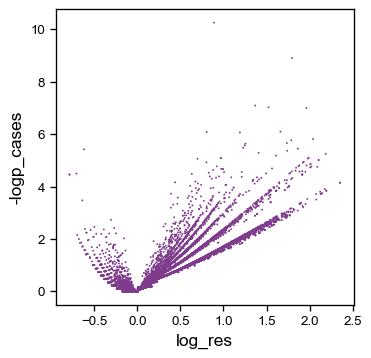

In [367]:
import seaborn as sns
fig, ax = plt.subplots(1, figsize = (4, 4))
sns.scatterplot(x = 'log_res', y = '-logp_cases', data = test_sig, s = 2, ec = None)

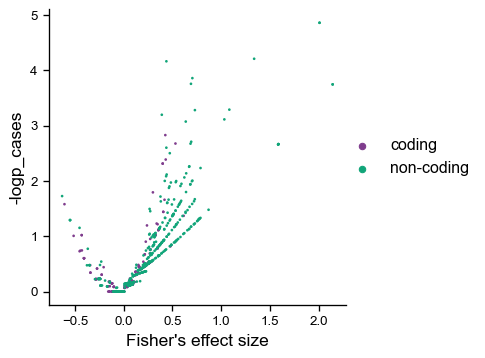

In [393]:
hallmark_results = test_sig.query('db == "MSigDB_Hallmark_2020"')
fig, ax = plt.subplots(1, figsize = (4, 4))
sns.scatterplot(x = 'log_res', y = '-logp_cases', 
                data = hallmark_results, s = 4, ec = None, hue = 'sv_category')
sns.despine(ax = ax)
ax.set_xlabel("Fisher's effect size")
ax.legend(bbox_to_anchor = (0.95, 0.5))
fig.savefig('images/cwas/gene-enrichment-hallmark-significance.png', bbox_inches = 'tight')

In [396]:
hallmark_results.query('p_cases < 0.05').groupby(['sv_category'])['gs'].value_counts().head(15)

sv_category  gs                       
coding       Adipogenesis                  6
             Myogenesis                    2
             Angiogenesis                  1
             Xenobiotic Metabolism         1
             mTORC1 Signaling              1
non-coding   mTORC1 Signaling             14
             Estrogen Response Late        7
             Unfolded Protein Response     7
             Glycolysis                    5
             Hedgehog Signaling            5
             UV Response Dn                4
             heme Metabolism               4
             Adipogenesis                  3
             Allograft Rejection           3
             G2-M Checkpoint               3
Name: gs, dtype: int64

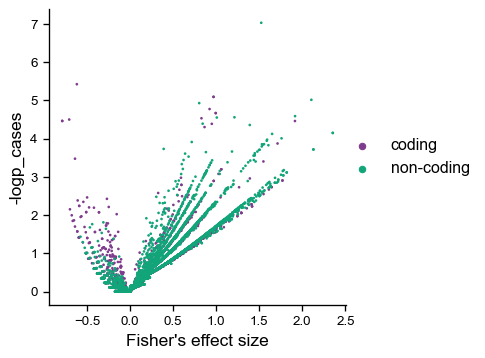

In [416]:
reactome_results = test_sig.query('db == "Reactome_2022"')
fig, ax = plt.subplots(1, figsize = (4, 4))
sns.scatterplot(x = 'log_res', y = '-logp_cases', 
                data = reactome_results, s = 4, ec = None, hue = 'sv_category')
sns.despine(ax = ax)
ax.set_xlabel("Fisher's effect size")
ax.legend(bbox_to_anchor = (0.95, 0.5))
fig.savefig('images/cwas/gene-enrichment-reactome-significance.png', bbox_inches = 'tight')

In [411]:
reactome_results.query('p_cases < 0.05').groupby(['sv_category'])['gs'].value_counts()

sv_category  gs                                                                            
coding       Mitochondrial Fatty Acid Beta-Oxidation Of Unsaturated Fatty Acids R-HSA-77288    10
             Cytokine Signaling In Immune System R-HSA-1280215                                  9
             Beta Defensins R-HSA-1461957                                                       8
             Defensins R-HSA-1461973                                                            8
             Formation Of Xylulose-5-Phosphate R-HSA-5661270                                    8
                                                                                               ..
non-coding   Uptake And Function Of Anthrax Toxins R-HSA-5210891                                1
             VEGFA-VEGFR2 Pathway R-HSA-4420097                                                 1
             WNT Ligand Biogenesis And Trafficking R-HSA-3238698                                1
             tRNA Processi

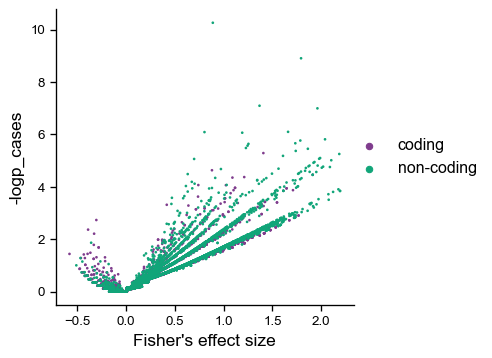

In [417]:
go_results = test_sig.query('db == "GO_Biological_Process_Specific"')
fig, ax = plt.subplots(1, figsize = (4, 4))
sns.scatterplot(x = 'log_res', y = '-logp_cases', 
                data = go_results, s = 4, ec = None, hue = 'sv_category')
sns.despine(ax = ax)
ax.set_xlabel("Fisher's effect size")
ax.legend(bbox_to_anchor = (0.95, 0.5))
fig.savefig('images/cwas/gene-enrichment-GO-significance.png', bbox_inches = 'tight')

In [421]:
go_results.query('p_cases < 0.05').groupby(['sv_category'])['gs'].value_counts()

sv_category  gs                                                  
coding       brain development (GO:0007420)                          10
             piecemeal microautophagy of the nucleus (GO:0034727)    10
             retina homeostasis (GO:0001895)                         10
             sphingomyelin biosynthetic process (GO:0006686)          9
             behavioral response to pain (GO:0048266)                 8
                                                                     ..
non-coding   vesicle cargo loading (GO:0035459)                       1
             viral protein processing (GO:0019082)                    1
             wound healing (GO:0042060)                               1
             xenobiotic metabolic process (GO:0006805)                1
             xenobiotic transport (GO:0042908)                        1
Name: gs, Length: 943, dtype: int64

# Overlap with expression

In [422]:
# read in expression data
expression_results = pd.read_csv('data/cwas-results/expression-significance.csv')
sv_gene_results = pd.read_csv('data/cwas-results/sv-gene-expression-results.csv')

In [505]:
expression_results.query('p_mean < 0.05').shape

(10, 9)

In [493]:
sig_coding_categories = expression_results.query('p_mean < 0.05')['category'].tolist()
sig_coding_results = gse_results[gse_results['category'].isin(sig_coding_categories)]
sig_coding_results = sig_coding_results.query('gs_unique_overlap_cases > 1 & db != "GO_Biological_Process_Full & p_controls < 0.05"')
sig_coding_results = sig_coding_results[sig_coding_results.apply(lambda row: int(row['expected'].split('/')[0]) >= 5, axis = 1)]


In [494]:
sig_coding_results['category'].value_counts()

ANY.SINGLETON.ANY.ANY.ANY.protein_coding                                                                   3571
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding                           2885
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding                                            2584
DEL.SINGLETON.ANY.ANY.ANY.protein_coding                                                                   2582
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding                           2582
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding    1865
ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding                                                         1819
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding                 1212
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding                                                      

In [495]:
sig_coding_results.query('p_cases < 0.05').groupby('db')['gs'].value_counts()

db                          gs                                                                     
GO_Biological_Process_Full  C-terminal protein lipidation (GO:0006501)                                 10
                            actin-myosin filament sliding (GO:0033275)                                 10
                            carbohydrate phosphorylation (GO:0046835)                                  10
                            cell communication (GO:0007154)                                            10
                            detection of temperature stimulus (GO:0016048)                             10
                                                                                                       ..
Reactome_2022               Synthesis Of PIPs At Golgi Membrane R-HSA-1660514                           1
                            Telomere C-strand (Lagging Strand) Synthesis R-HSA-174417                   1
                            Transcription-Coupled Nu

In [507]:
sig_coding_results.query('p_cases < 0.05 & db == "GO_Biological_Process_Specific"').groupby('db')['gs'].value_counts().head(15)

db                              gs                                                                                   
GO_Biological_Process_Specific  brain development (GO:0007420)                                                           10
                                medium-chain fatty acid catabolic process (GO:0051793)                                   10
                                photoreceptor cell outer segment organization (GO:0035845)                               10
                                piecemeal microautophagy of the nucleus (GO:0034727)                                     10
                                retina homeostasis (GO:0001895)                                                          10
                                serotonin uptake (GO:0051610)                                                            10
                                positive regulation of transcription by RNA polymerase II (GO:0045944)                    9
              

In [508]:
sig_coding_results.query('p_cases < 0.05 & db == "MSigDB_Hallmark_2020"').groupby('db')['gs'].value_counts().head(15)

db                    gs                   
MSigDB_Hallmark_2020  Adipogenesis             7
                      Myogenesis               2
                      Angiogenesis             1
                      Xenobiotic Metabolism    1
                      mTORC1 Signaling         1
Name: gs, dtype: int64

In [509]:
sig_coding_results.query('p_cases < 0.05 & db == "Reactome_2022"').groupby('db')['gs'].value_counts().head(15)

db             gs                                                                                   
Reactome_2022  Mitochondrial Fatty Acid Beta-Oxidation Of Unsaturated Fatty Acids R-HSA-77288           10
               Abacavir ADME R-HSA-2161522                                                               9
               Cytokine Signaling In Immune System R-HSA-1280215                                         9
               Acyl Chain Remodelling Of PE R-HSA-1482839                                                8
               Beta Defensins R-HSA-1461957                                                              8
               Defensins R-HSA-1461973                                                                   8
               Formation Of Xylulose-5-Phosphate R-HSA-5661270                                           8
               Infectious Disease R-HSA-5663205                                                          8
               Antimicrobial Peptides R-HSA

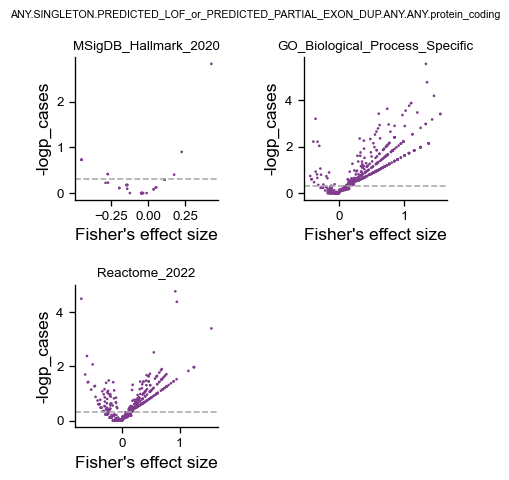

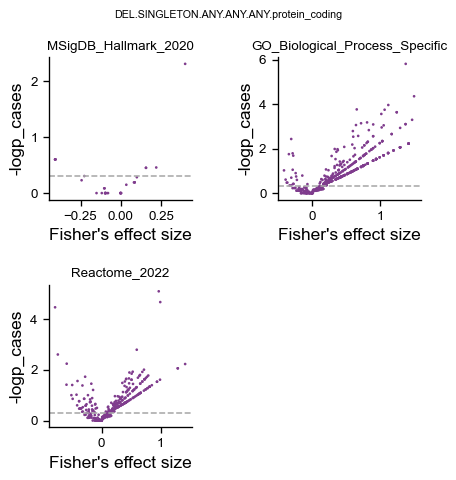

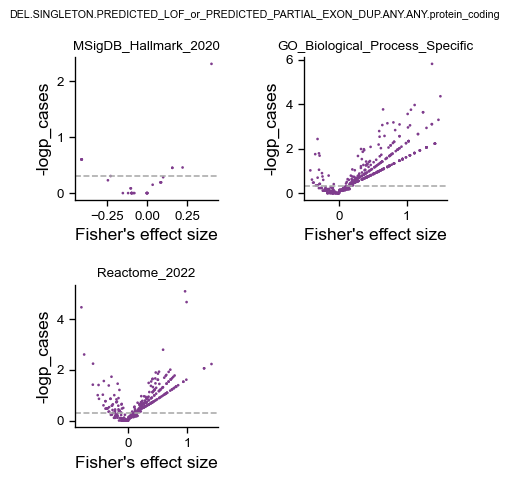

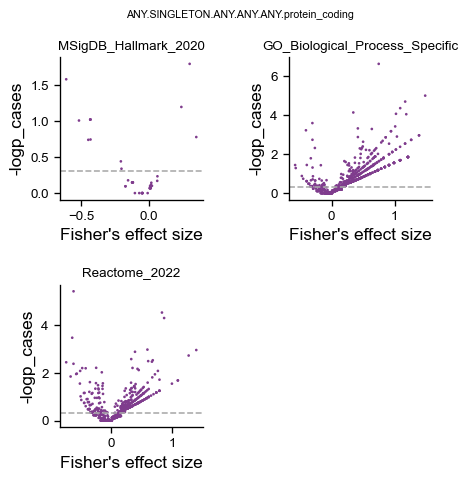

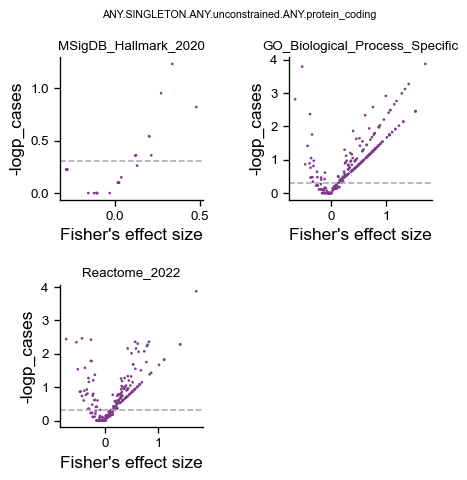

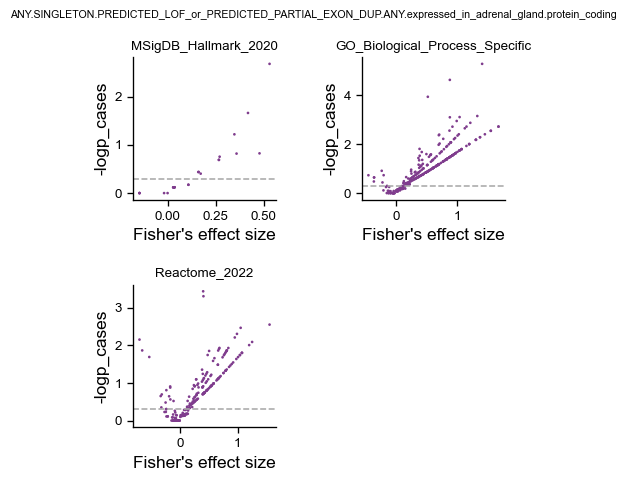

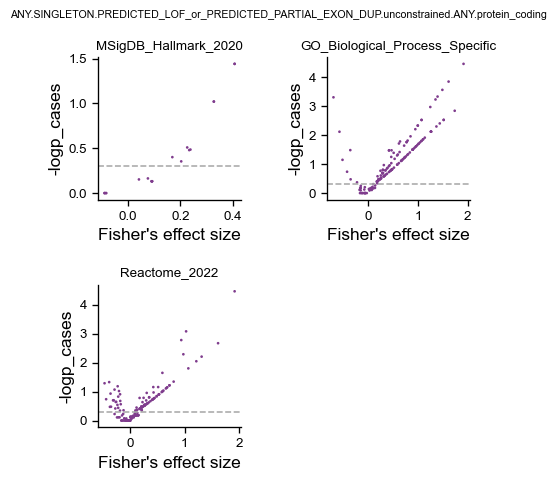

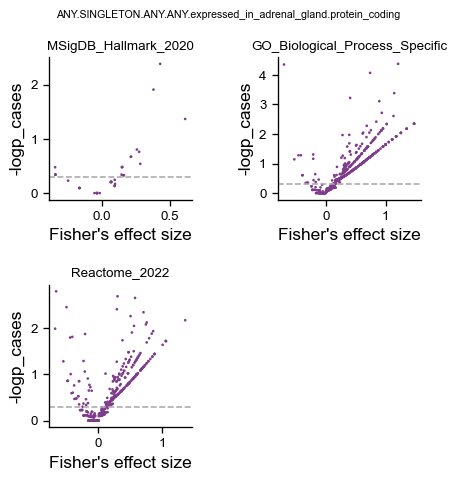

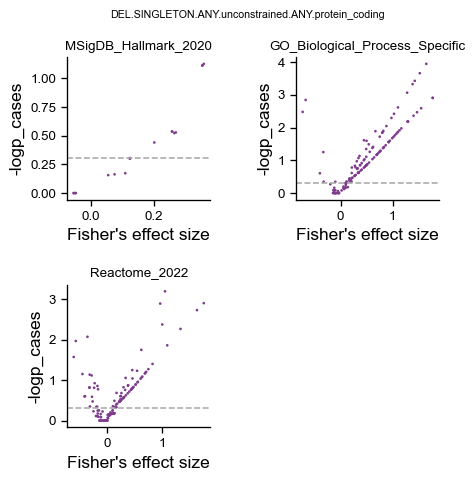

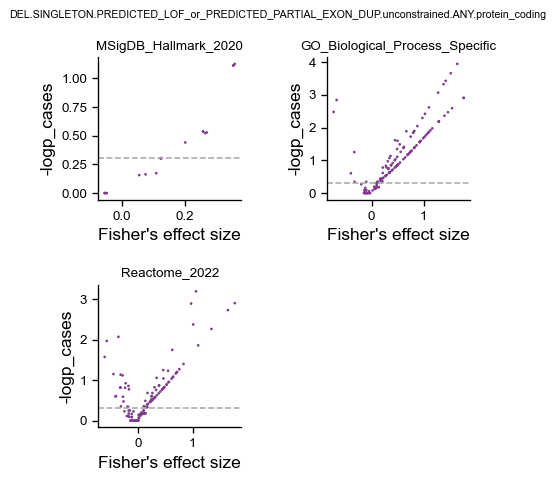

In [473]:
for cat in sig_coding_categories:
    cat_results = sig_coding_results[sig_coding_results['category'] == cat].copy()
    
    cat_results['-logp_cases'] = -np.log10(cat_results['p_cases'])
    cat_results['log_res'] = np.log10(cat_results['res_cases'])
    
    fig, axes = plt.subplots(2, 2, figsize = (5, 5), 
                             gridspec_kw = {'hspace': 0.6, 'wspace': 0.6})
    for i, db in enumerate(['MSigDB_Hallmark_2020', 'GO_Biological_Process_Specific', 'Reactome_2022']):
        db_results = cat_results[cat_results['db'] == db].copy()
        
        ax = axes.flat[i]
        sns.scatterplot(x = 'log_res', y = '-logp_cases',
                        data = db_results, s = 4, ec = None, ax = ax)

        sns.despine(ax = ax)
        ax.set_xlabel("Fisher's effect size")
        ax.axhline(y = -np.log10(0.5), linestyle = 'dashed', color = 'darkgrey')
        
        axes.flat[i].set_title(db, fontsize = 10)
        
    axes.flat[-1].axis('off')
    fig.suptitle(cat, fontsize = 8)
    
    fig.savefig(f'data/cwas-results/gene-set-plots/{cat}.png', bbox_inches = 'tight')